In [53]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import xgboost as xgb
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics


In [26]:
df = pd.read_csv("datasets/Generacion_fotovoltaica.csv", sep=",")

In [27]:
# Rename columns to Prophet defaults
df.rename(columns={'FECHA': 'ds', 'TOTAL_KWH_ENERGIA': 'y'}, inplace=True)
# Convert the 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'])


df['hour'] = df['ds'].dt.hour
df['y'] = df['y'].clip(lower=0)
df.loc[df['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5, 6, 7]) & df['y'].isnull(), 'y'] = 0

# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Apply the imputer to the 'y' column
df['y'] = imputer.fit_transform(df[['y']])
df = df[['ds', 'y']].copy()
df

,ds,y
0,2023-07-24 11:00:00,24.085597
1,2023-07-24 12:00:00,115.660000
2,2023-07-24 13:00:00,129.980000
3,2023-07-24 14:00:00,134.350000
4,2023-07-24 15:00:00,133.900000
...,...,...
9703,2024-08-31 19:00:00,24.085597
9704,2024-08-31 20:00:00,24.085597
9705,2024-08-31 21:00:00,24.085597
9706,2024-08-31 22:00:00,0.000000


In [ ]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=720,freq='h')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:57 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
df_cv = cross_validation(
    model=m,
    initial='300 days',
    period='7 days',
    horizon='7 days'
)

df_p = performance_metrics(df_cv)
df_p.head()

  0%|          | 0/14 [00:00<?, ?it/s]16:54:06 - cmdstanpy - INFO - Chain [1] start processing
16:54:06 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/14 [00:00<00:09,  1.35it/s]16:54:07 - cmdstanpy - INFO - Chain [1] start processing
16:54:07 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 2/14 [00:01<00:09,  1.33it/s]16:54:08 - cmdstanpy - INFO - Chain [1] start processing
16:54:08 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 3/14 [00:02<00:08,  1.32it/s]16:54:08 - cmdstanpy - INFO - Chain [1] start processing
16:54:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 4/14 [00:03<00:07,  1.33it/s]16:54:09 - cmdstanpy - INFO - Chain [1] start processing
16:54:10 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 5/14 [00:03<00:07,  1.26it/s]16:54:10 - cmdstanpy - INFO - Chain [1] start processing
16:54:10 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 6/14 [00:04<00:06,  1.30it/s]16:54:11

,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 17:00:00,710.815109,26.661116,20.207480,4.209915,1.453282,0.719149
1,0 days 18:00:00,825.818682,28.737061,22.246887,3.544261,1.382406,0.672340
2,0 days 19:00:00,913.313539,30.221078,23.799332,3.087352,1.306579,0.642553
3,0 days 20:00:00,930.642968,30.506441,24.159796,1.973447,1.215783,0.634043
4,0 days 21:00:00,935.060457,30.578758,24.323278,1.565559,1.137221,0.634043


In [56]:
for cps in [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5]:
    m = Prophet(changepoint_prior_scale=cps, daily_seasonality=True, weekly_seasonality=True)
    m.fit(df)
    df_cv = cross_validation(m, initial='300 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv)
    print(f'cps={cps}, RMSE={df_p["rmse"].mean():.2f}, Coverage={df_p["coverage"].mean():.2f}')

16:55:12 - cmdstanpy - INFO - Chain [1] start processing
16:55:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/14 [00:00<?, ?it/s]16:55:13 - cmdstanpy - INFO - Chain [1] start processing
16:55:13 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/14 [00:00<00:06,  1.88it/s]16:55:13 - cmdstanpy - INFO - Chain [1] start processing
16:55:14 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 2/14 [00:01<00:08,  1.41it/s]16:55:14 - cmdstanpy - INFO - Chain [1] start processing
16:55:15 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 3/14 [00:02<00:08,  1.35it/s]16:55:15 - cmdstanpy - INFO - Chain [1] start processing
16:55:16 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 4/14 [00:03<00:08,  1.19it/s]16:55:16 - cmdstanpy - INFO - Chain [1] start processing
16:55:17 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 5/14 [00:03<00:07,  1.18it/s]16:55:17 - cmdstanpy - INFO - Chain [1] start processi

cps=0.001, RMSE=25.28, Coverage=0.74


16:55:24 - cmdstanpy - INFO - Chain [1] start processing
16:55:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/14 [00:00<?, ?it/s]16:55:25 - cmdstanpy - INFO - Chain [1] start processing
16:55:25 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/14 [00:00<00:07,  1.81it/s]16:55:26 - cmdstanpy - INFO - Chain [1] start processing
16:55:26 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 2/14 [00:01<00:06,  1.91it/s]16:55:26 - cmdstanpy - INFO - Chain [1] start processing
16:55:26 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 3/14 [00:01<00:05,  2.00it/s]16:55:26 - cmdstanpy - INFO - Chain [1] start processing
16:55:27 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 4/14 [00:01<00:04,  2.05it/s]16:55:27 - cmdstanpy - INFO - Chain [1] start processing
16:55:27 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 5/14 [00:02<00:04,  2.01it/s]16:55:28 - cmdstanpy - INFO - Chain [1] start processi

cps=0.01, RMSE=25.55, Coverage=0.75


16:55:33 - cmdstanpy - INFO - Chain [1] start processing
16:55:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/14 [00:00<?, ?it/s]16:55:34 - cmdstanpy - INFO - Chain [1] start processing
16:55:34 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/14 [00:00<00:08,  1.56it/s]16:55:35 - cmdstanpy - INFO - Chain [1] start processing
16:55:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 2/14 [00:01<00:08,  1.50it/s]16:55:35 - cmdstanpy - INFO - Chain [1] start processing
16:55:36 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 3/14 [00:02<00:07,  1.45it/s]16:55:36 - cmdstanpy - INFO - Chain [1] start processing
16:55:37 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 4/14 [00:02<00:07,  1.33it/s]16:55:37 - cmdstanpy - INFO - Chain [1] start processing
16:55:37 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 5/14 [00:03<00:06,  1.29it/s]16:55:38 - cmdstanpy - INFO - Chain [1] start processi

cps=0.1, RMSE=25.39, Coverage=0.74


16:55:47 - cmdstanpy - INFO - Chain [1] start processing
16:55:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/14 [00:00<?, ?it/s]16:55:49 - cmdstanpy - INFO - Chain [1] start processing
16:55:49 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/14 [00:00<00:11,  1.16it/s]16:55:49 - cmdstanpy - INFO - Chain [1] start processing
16:55:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 2/14 [00:01<00:11,  1.06it/s]16:55:50 - cmdstanpy - INFO - Chain [1] start processing
16:55:51 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 3/14 [00:02<00:10,  1.05it/s]16:55:51 - cmdstanpy - INFO - Chain [1] start processing
16:55:53 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 4/14 [00:04<00:11,  1.18s/it]16:55:53 - cmdstanpy - INFO - Chain [1] start processing
16:55:54 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 5/14 [00:05<00:10,  1.18s/it]16:55:54 - cmdstanpy - INFO - Chain [1] start processi

cps=0.3, RMSE=25.35, Coverage=0.74


16:56:08 - cmdstanpy - INFO - Chain [1] start processing
16:56:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/14 [00:00<?, ?it/s]16:56:10 - cmdstanpy - INFO - Chain [1] start processing
16:56:12 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/14 [00:01<00:20,  1.57s/it]16:56:12 - cmdstanpy - INFO - Chain [1] start processing
16:56:13 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 2/14 [00:03<00:18,  1.52s/it]16:56:13 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 3/14 [00:04<00:16,  1.46s/it]16:56:15 - cmdstanpy - INFO - Chain [1] start processing
16:56:16 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 4/14 [00:06<00:16,  1.63s/it]16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:18 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 5/14 [00:07<00:14,  1.59s/it]16:56:18 - cmdstanpy - INFO - Chain [1] start processi

cps=0.5, RMSE=25.33, Coverage=0.73


In [58]:
m = Prophet(
    changepoint_prior_scale=0.01,
    daily_seasonality=True,
    weekly_seasonality=True
)

m.fit(df)
future = m.make_future_dataframe(periods=720,freq='h')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

17:00:43 - cmdstanpy - INFO - Chain [1] start processing
17:00:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2023-07-24 11:00:00,57.393095,25.088834,88.008599
1,2023-07-24 12:00:00,73.322962,42.512108,104.728720
2,2023-07-24 13:00:00,82.568214,50.504448,112.784173
3,2023-07-24 14:00:00,84.912600,51.193030,115.450136
4,2023-07-24 15:00:00,82.282074,51.329745,113.929345


In [59]:
preds = forecast[['ds', 'yhat']]
preds = preds[preds['ds'] >= '2024-09-01']
preds = preds[['ds', 'yhat']]
preds['yhat'] = preds['yhat'].apply(lambda x: 0 if x < 0.5 else x)
preds.to_csv('prophet_try.csv')

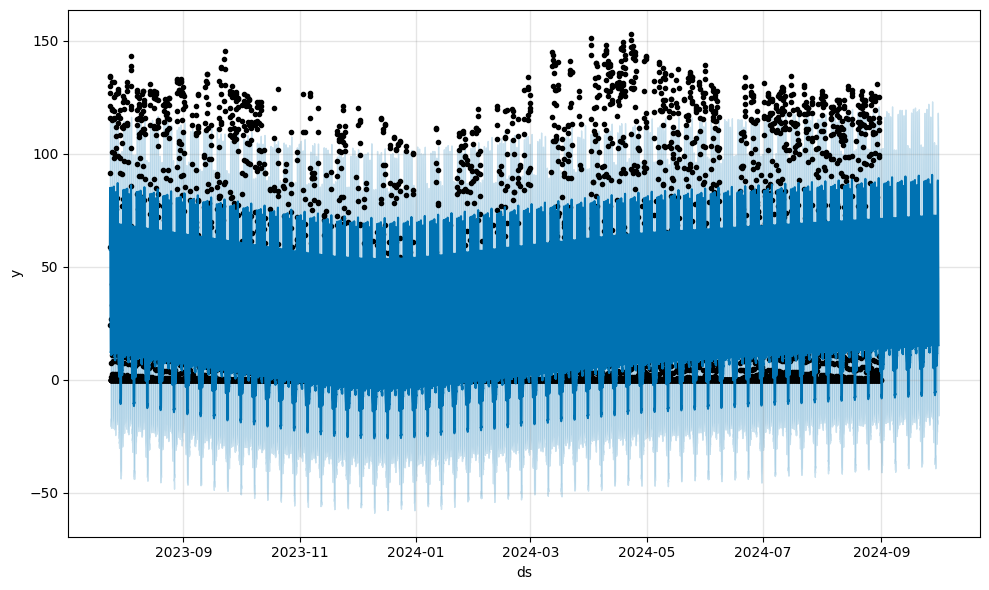

In [60]:
fig1 = m.plot(forecast)

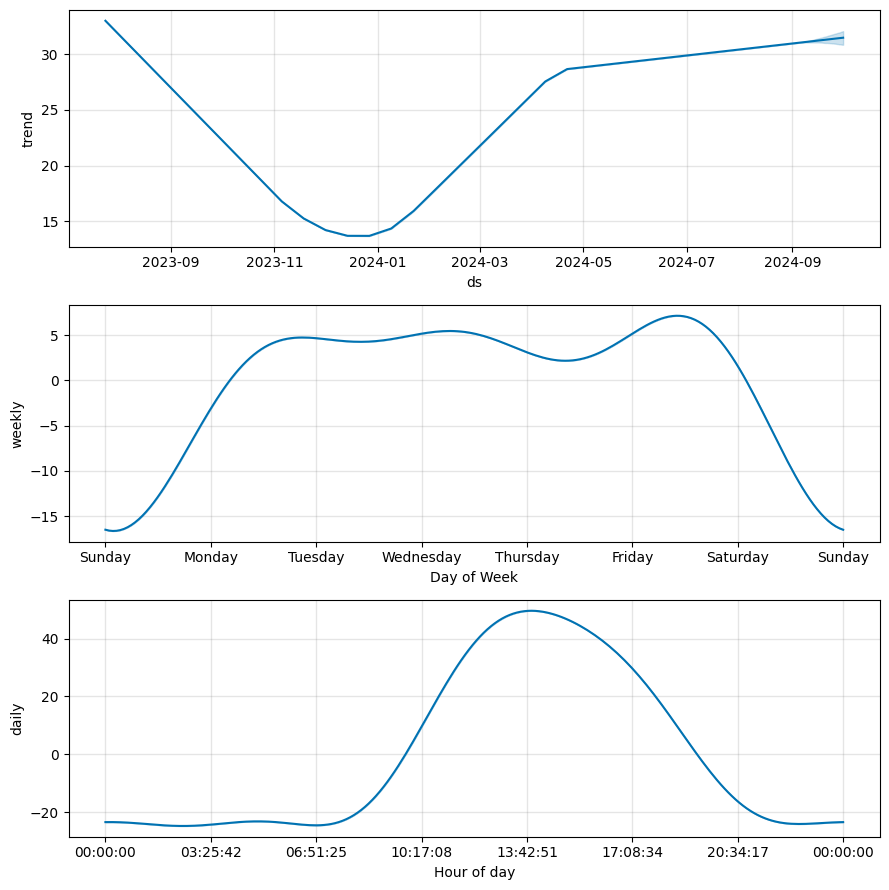

In [32]:
fig2 = m.plot_components(forecast)